Nour Mansour and Juan Estrella

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Part 1: Data Collection

Step 1: Get the tsv data

In [31]:
# Data is saved in the same folder as the project. Then read data from tsv file
data = pd.read_csv("train-balanced-sarcasm.csv")
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


Part 2: Data Processing

Step 1: Columns required: Label, Comments, subreddit, parent comment

Step 2: Create a Dataframe containing an even amount of sarcastic and non sarcastic 
comments, amount of data is 505413 each. 

In [32]:
#Copy the only the data we need
required_data = data[['label','comment','subreddit','parent_comment']]
required_data.head()

,label,comment,subreddit,parent_comment
0,0,NC and NH.,politics,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...


In [33]:
#Divide the required data set to sarcastic and non sarcastic
non_sarcastic = required_data.loc[required_data['label'] == 0]
sarcastic = required_data.loc[required_data['label'] == 1]
print(len(non_sarcastic), len(sarcastic))

505413 505413


Part 3: Exploratory Analysis & Data Visualization

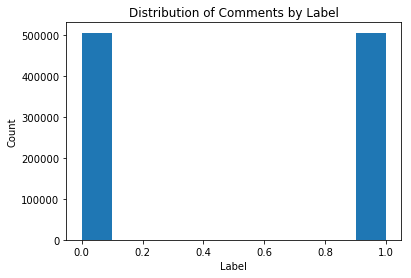

In [34]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
plt.hist(data.label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Comments by Label')
plt.show()

In [35]:
# Explore distribution of comments by label 
data.groupby('label').describe()

score                                                          ups  \
          count      mean        std    min  25%  50%  75%     max     count   
label                                                                          
0      505413.0  7.370436  55.991749 -298.0  1.0  2.0  4.0  5818.0  505413.0   
1      505413.0  6.400916  39.224064 -507.0  1.0  2.0  5.0  9070.0  505413.0   

                 ...                  downs                                \
           mean  ...  75%     max     count      mean       std  min  25%   
label            ...                                                        
0      5.775277  ...  3.0  5163.0  505413.0 -0.166175  0.372238 -1.0  0.0   
1      5.222493  ...  4.0  4010.0  505413.0 -0.125551  0.331343 -1.0  0.0   

                      
       50%  75%  max  
label                 
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  

[2 rows x 24 columns]

In [ ]:
#We w